# Converting dataset to ShareGPT

In [1]:
%%capture
from datasets import load_dataset   

dataset = load_dataset("CarterPiepenburg/code-search-net-java-docgen", split="train")

In [2]:
def to_sharegpt(dataset, merged_prompt, output_column_name, conversation_extension=1):
    """
    Convert dataset to ShareGPT format with proper variable substitution

    Args:
        dataset: The source dataset
        merged_prompt: Template string with {column_name} placeholders
        output_column_name: Column to use as the output/completion
        conversation_extension: Number of examples to combine into a single conversation
    """
    formatted_data = []

    for i in range(0, len(dataset), conversation_extension):
        conversation = []

        # Process each example in the current conversation window
        for j in range(i, min(i + conversation_extension, len(dataset))):
            example = dataset[j]

            # Format the prompt by substituting variables
            prompt = merged_prompt
            for column in dataset.column_names:
                if column in merged_prompt and column in example:
                    placeholder = "{" + column + "}"
                    prompt = prompt.replace(placeholder, str(example[column]))

            # Add the human message
            conversation.append({
                "from": "human",
                "value": prompt
            })

            # Add the assistant message
            conversation.append({
                "from": "assistant",
                "value": example[output_column_name]
            })

        # Add the conversation to the formatted data
        formatted_data.append({"conversations": conversation})

    return formatted_data

In [3]:
# For code explanation
code_explain_dataset = to_sharegpt(
    dataset,
    merged_prompt = """Write a description for this Java function: {code}""",
    output_column_name = "response"
)

In [4]:
code_explain_dataset[0]

{'conversations': [{'from': 'human',
   'value': 'Write a description for this Java function: @Override\n    public ImageSource apply(ImageSource input) {\n        final int[][] pixelMatrix = new int[3][3];\n\n        int w = input.getWidth();\n        int h = input.getHeight();\n\n        int[][] output = new int[h][w];\n\n        for (int j = 1; j < h - 1; j++) {\n            for (int i = 1; i < w - 1; i++) {\n                pixelMatrix[0][0] = input.getR(i - 1, j - 1);\n                pixelMatrix[0][1] = input.getRGB(i - 1, j);\n                pixelMatrix[0][2] = input.getRGB(i - 1, j + 1);\n                pixelMatrix[1][0] = input.getRGB(i, j - 1);\n                pixelMatrix[1][2] = input.getRGB(i, j + 1);\n                pixelMatrix[2][0] = input.getRGB(i + 1, j - 1);\n                pixelMatrix[2][1] = input.getRGB(i + 1, j);\n                pixelMatrix[2][2] = input.getRGB(i + 1, j + 1);\n\n                int edge = (int) convolution(pixelMatrix);\n                int 

# Initialize Model and Token Register

In [5]:
from unsloth import FastLanguageModel
import torch

max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.


model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen2.5-1.5B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


C:\Users\carte\compsci\411\aiproject\new.venv\Lib\site-packages\unsloth_zoo\gradient_checkpointing.py:330: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  GPU_BUFFERS = tuple([torch.empty(2*256*2048, dtype = dtype, device = f"cuda:{i}") for i in range(n_gpus)])


==((====))==  Unsloth 2025.4.7: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 3060 Laptop GPU. Num GPUs = 1. Max memory: 6.0 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.7.0+cu128. CUDA: 8.6. CUDA Toolkit: 12.8. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [6]:
from datasets import Dataset

# First, convert your list to a Hugging Face Dataset
code_explain_dataset_hf = Dataset.from_list(code_explain_dataset)

In [7]:
from unsloth import standardize_sharegpt
dataset = standardize_sharegpt(code_explain_dataset_hf)

Unsloth: Standardizing formats (num_proc=16):   0%|          | 0/1000 [00:00<?, ? examples/s]

In [8]:
from unsloth import apply_chat_template
chat_template = """
{SYSTEM}
USER: {INPUT}
ASSISTANT: {OUTPUT}"""

default_system_message = """
You are generating brief documentation for a Java code snippet.
Your response MUST be a single paragraph with NO bulletpoints, NO line breaks, and NO section headers.
Do NOT explain the prompt. Just output the summary.
Keep your explanation short and focused. Avoid repetition.
Start your response with (This function)
Summarize ONLY the core logic and purpose of the code.
Here is the Java code:
Summary (one paragraph only): """


In [9]:
# Use this system message with the apply_chat_template function
dataset = apply_chat_template(
    dataset,
    tokenizer = tokenizer,
    chat_template = chat_template,
    default_system_message = default_system_message
)

Unsloth: We automatically added an EOS token to stop endless generations.


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [10]:
dataset[2]

{'conversations': [{'content': 'Write a description for this Java function: protected void modify(Transaction t) {\n        try {\n            this.lock.writeLock().lock();\n            t.perform();\n        } finally {\n            this.lock.writeLock().unlock();\n        }\n    }',
   'role': 'user'},
  {'content': "This function `modify` executes a transaction (`t`) in a synchronized manner. It ensures exclusive access to the resource by acquiring and releasing a write lock using Java's `ReentrantReadWriteLock`. The core logic is that this function locks the resource before executing any operations on the transaction (`t.perform()`), ensuring no other thread can interfere with these operations while the transaction is being executed.",
   'role': 'assistant'}],
 'text': "\nYou are generating brief documentation for a Java code snippet.\nYour response MUST be a single paragraph with NO bulletpoints, NO line breaks, and NO section headers.\nDo NOT explain the prompt. Just output the s

# Training Model

In [11]:
split_dataset = dataset.train_test_split(test_size=0.3) #0.1
train_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]

In [12]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen2.5-1.5B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth 2025.4.7: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 3060 Laptop GPU. Num GPUs = 1. Max memory: 6.0 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.7.0+cu128. CUDA: 8.6. CUDA Toolkit: 12.8. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [13]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 32, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
    "gate_proj", "up_proj", "down_proj" ,],
    lora_alpha = 16,
    lora_dropout = 0.05, # Supports any, but = 0 is optimized
    bias = "none",
    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 42,
    use_rslora = True,
    # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.4.7 patched 28 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


In [14]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 1,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 8,
        gradient_accumulation_steps = 8,
        #warmup_steps = 5,
        warmup_steps = 20,
        #max_steps = 20,
        num_train_epochs = 2,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "ft-outputs",
        report_to = [],
    ),
)

Unsloth: Tokenizing ["text"]:   0%|          | 0/700 [00:00<?, ? examples/s]

In [15]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 700 | Num Epochs = 2 | Total steps = 22
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 8 x 1) = 64
 "-____-"     Trainable parameters = 36,929,536/5,000,000,000 (0.74% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.073500
2,2.007600
3,1.996600
4,2.011900
5,1.905500
6,1.846800
7,1.771100
8,1.665800
9,1.530700
10,1.322800


TrainOutput(global_step=22, training_loss=1.3019090321930973, metrics={'train_runtime': 441.1509, 'train_samples_per_second': 3.174, 'train_steps_per_second': 0.05, 'total_flos': 5805785842458624.0, 'train_loss': 1.3019090321930973})

In [16]:
trainer.save_model("ft-outputs")

In [17]:
model.save_pretrained("ft-outputs")
tokenizer.save_pretrained("ft-outputs")

('ft-outputs\\tokenizer_config.json',
 'ft-outputs\\special_tokens_map.json',
 'ft-outputs\\vocab.json',
 'ft-outputs\\merges.txt',
 'ft-outputs\\added_tokens.json',
 'ft-outputs\\tokenizer.json')

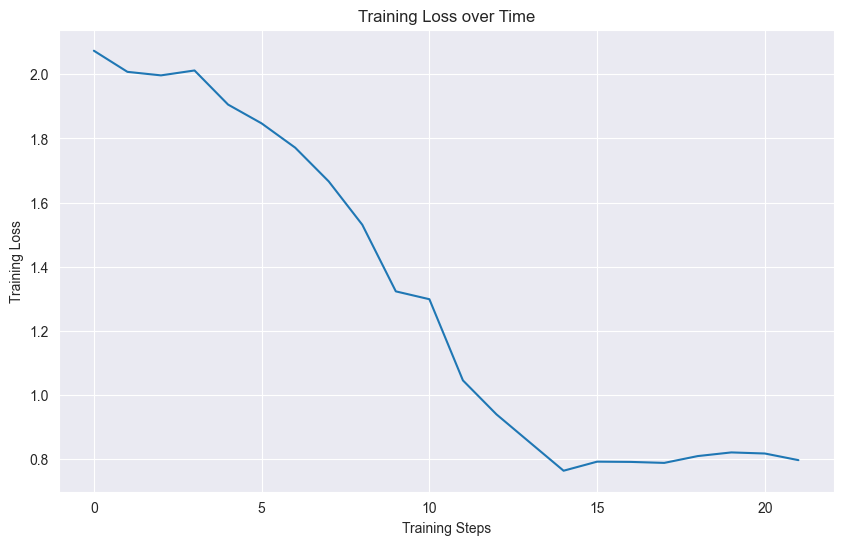

In [18]:
import matplotlib.pyplot as plt
import numpy as np
# After training is complete
training_logs = trainer.state.log_history
# Extract loss values
train_losses = [log.get('loss') for log in training_logs if 'loss' in log]
steps = list(range(len(train_losses)))
# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(steps, train_losses)
plt.xlabel('Training Steps')
plt.ylabel('Training Loss')
plt.title('Training Loss over Time')
plt.grid(True)
plt.show()

# Evaluation

In [19]:
import numpy as np
import json
import torch
from transformers import TextStreamer
from nltk.translate.bleu_score import sentence_bleu
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from safetensors import safe_open
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import torch
from peft import PeftModel, PeftConfig

In [20]:
# # Load the model and tokenizer from your saved directory
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="ft-outputs",
    max_seq_length=max_seq_length,
    dtype=torch.float16, # You can use bfloat16 if supported by your hardware
    load_in_4bit=True, # Assuming you're using the same quantization as during training
)

FastLanguageModel.for_inference(model)

# model, tokenizer = FastLanguageModel.from_pretrained(
#     model_name = "unsloth/Qwen2.5-1.5B",
#     max_seq_length = max_seq_length,
#     dtype = dtype,
#     device_map="auto",
# )
# model = PeftModel.from_pretrained(model, "ft-outputs")
# model = model.merge_and_unload()
# 
# tokenizer = AutoTokenizer.from_pretrained("ft-outputs")

==((====))==  Unsloth 2025.4.7: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 3060 Laptop GPU. Num GPUs = 1. Max memory: 6.0 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.7.0+cu128. CUDA: 8.6. CUDA Toolkit: 12.8. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(151936, 1536, padding_idx=151654)
        (layers): ModuleList(
          (0): Qwen2DecoderLayer(
            (self_attn): Qwen2Attention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=1536, out_features=1536, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1536, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=1536, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): 

In [ ]:
#Clear gpu
# del model
# torch.cuda.empty_cache()
# torch.cuda.synchronize()

In [21]:
chat_template = """
{SYSTEM}
USER: {INPUT}
ASSISTANT: {OUTPUT}"""

system_message = """
You are generating brief documentation for a Java code snippet.
Your response MUST be a single paragraph with NO bulletpoints, NO line breaks, and NO section headers.
Do NOT explain the prompt. Just output the summary.
Keep your explanation short and focused. Avoid repetition.
Start your response with (This function)
Summarize ONLY the core logic and purpose of the code.
Here is the Java code:
Summary (one paragraph only): """

In [22]:
def apply_chat_template(messages, system_message, user_message):
    chat_input = chat_template.format(
        SYSTEM=system_message,
        INPUT=user_message,
        OUTPUT=""
    )
    return chat_input

In [23]:
# Function to run inference on a single example
def generate_explanation(code_to_explain):
    # Prepare user message with Java code for explanation
    user_message = f"""Write a description for this Java function: {code_to_explain}"""

    formatted_input = apply_chat_template(messages=None, system_message=system_message, user_message=user_message)

    #Tokenize the formatted input
    input_ids = tokenizer(formatted_input, return_tensors="pt").to("cuda")
    
    ##Create the messages list with the system message and user message
    # messages = [
    #     {"role": "system", "content": system_message},
    #     {"role": "user", "content": user_message}
    # ]
    # # Apply chat template to format the input consistently with how you trained
    # input_ids = tokenizer.apply_chat_template(
    #     messages,
    #     add_generation_prompt=True,
    #     return_tensors="pt"
    # ).to("cuda")

    # Generate the response
    with torch.no_grad():
        outputs = model.generate(
            input_ids['input_ids'],
            attention_mask=input_ids['attention_mask'],
            max_new_tokens=256,
            pad_token_id=tokenizer.eos_token_id,
            temperature=0.7,
            top_p=0.9,
            repetition_penalty=1.1
        )

    # Decode the output, skipping the prompt
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text

In [24]:
# Process examples from rows 700 to 1000
results = []
start_idx = 0
end_idx = 50


# Convert to list if it's a Dataset object to ensure proper indexing
if hasattr(test_dataset, 'to_list'):
    dataset_list = test_dataset.to_list()
else:
    dataset_list = test_dataset

# Make sure we don't exceed the dataset length
end_idx = min(end_idx, len(dataset_list) - 1)
subset = dataset_list[start_idx:end_idx + 1]

print(f"Processing examples from index {start_idx} to {end_idx}")

# Create results directory if it doesn't exist
import os
os.makedirs("evaluation_results", exist_ok=True)

for i, example in enumerate(subset):
    # Extract the code from the user message
    if "conversations" in example:
        user_message = example["conversations"][0]["content"]
        # Extract just the code part (assuming it starts after "Explain what this Python code does: ")
        if """Write a description for this Java function:""" in user_message:
            code_part = user_message.split("""Write a description for this Java function:""")[1]
        else:
            code_part = user_message  # If no prefix, use the whole message

        # Generate explanation for this code
        explanation = generate_explanation(code_part)

        # Get the reference explanation
        reference_explanation = example["conversations"][1]["content"] if len(example["conversations"]) > 1 else ""

        # Store results
        results.append({
            "index": start_idx + i,
            "code": code_part,
            "reference_explanation": reference_explanation,
            "generated_explanation": explanation
        })

        # Print progress
        print(f"Processed example {start_idx + i} ({i + 1}/{len(subset)})")

        # Print the explanation
        print(f"Original code: {code_part[:100]}...")
        print(f"Generated explanation: {explanation}")
        print("-" * 50)

# Save raw results to a file
with open("evaluation_results/inference_results_0_50.json", "w") as f:
    json.dump(results, f, indent=2)

print(f"Raw results saved to evaluation_results/inference_results_0_50.json")

Processing examples from index 0 to 50
Processed example 0 (1/51)
Original code:  public Set<D> getMatchedDeclaration() {
        Set<D> bindedSet = new HashSet<D>();
        for (M...
Generated explanation: 

You are generating brief documentation for a Java code snippet.
Your response MUST be a single paragraph with NO bulletpoints, NO line breaks, and NO section headers.
Do NOT explain the prompt. Just output the summary.
Keep your explanation short and focused. Avoid repetition.
Start your response with (This function)
Summarize ONLY the core logic and purpose of the code.
Here is the Java code:
Summary (one paragraph only): 
USER: Write a description for this Java function:  public Set<D> getMatchedDeclaration() {
        Set<D> bindedSet = new HashSet<D>();
        for (Map.Entry<ServiceReference<D>, Boolean> e : declarations.entrySet()) {
            if (e.getValue()) {
                bindedSet.add(getDeclaration(e.getKey()));
            }
        }
        return bindedSet;
 

In [25]:
# ============================
# 2. Semantic Similarity Evaluation
# ============================

def evaluate_semantic_similarity(results):
    # Load a sentence transformer model
    model = SentenceTransformer('all-MiniLM-L6-v2')

    similarities = []
    details = []

    for result in results:
        reference = result["reference_explanation"]
        generated = result["generated_explanation"]

        # Skip if either is empty
        if not reference or not generated:
            continue

        # Get embeddings
        ref_embedding = model.encode(reference)
        gen_embedding = model.encode(generated)

        # Calculate cosine similarity
        similarity = float(cosine_similarity([ref_embedding], [gen_embedding])[0][0])
        similarities.append(similarity)

        details.append({
            "index": result["index"],
            "similarity": similarity
        })

        print(f"Example {result['index']} similarity: {similarity:.4f}")

    avg_similarity = float(np.mean(similarities))
    median_similarity = float(np.median(similarities))
    min_similarity = float(np.min(similarities))
    max_similarity = float(np.max(similarities))
    std_similarity = float(np.std(similarities))

    print(f"Average semantic similarity: {avg_similarity:.4f}")
    print(f"Median semantic similarity: {median_similarity:.4f}")
    print(f"Min/Max similarity: {min_similarity:.4f}/{max_similarity:.4f}")
    print(f"Standard deviation: {std_similarity:.4f}")

    return {
        "summary": {
            "mean": avg_similarity,
            "median": median_similarity,
            "min": min_similarity,
            "max": max_similarity,
            "std": std_similarity
        },
        "details": details
    }

print("\n=== Running Semantic Similarity Evaluation ===\n")
semantic_metrics = evaluate_semantic_similarity(results)


=== Running Semantic Similarity Evaluation ===
Example 0 similarity: 0.4325
Example 1 similarity: 0.5314
Example 2 similarity: 0.5919
Example 3 similarity: 0.4482
Example 4 similarity: 0.4926
Example 5 similarity: 0.4900
Example 6 similarity: 0.5698
Example 7 similarity: 0.3165
Example 8 similarity: 0.5704
Example 9 similarity: 0.5135
Example 10 similarity: 0.5731
Example 11 similarity: 0.4985
Example 12 similarity: 0.3582
Example 13 similarity: 0.5038
Example 14 similarity: 0.4534
Example 15 similarity: 0.4500
Example 16 similarity: 0.3723
Example 17 similarity: 0.5290
Example 18 similarity: 0.4318
Example 19 similarity: 0.4261
Example 20 similarity: 0.4895
Example 21 similarity: 0.3713
Example 22 similarity: 0.5074
Example 23 similarity: 0.2953
Example 24 similarity: 0.5807
Example 25 similarity: 0.3405
Example 26 similarity: 0.4382
Example 27 similarity: 0.3603
Example 28 similarity: 0.5527
Example 29 similarity: 0.5412
Example 30 similarity: 0.4773
Example 31 similarity: 0.5740
Ex